# Appendix

This is a post-mortem analyzing the mistakes made by the model. Understanding Neural networks is a challending endeavor, as they are "black boxes". 

In [1]:
from os import scandir
import math

import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow as tf

from src.image_loader import load_images
from src.utils import one_hot, shuffle_n, arg_top_n, remove_ticks
from src.networks import AlexNet

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Reload the Data and Restore AlexNet model

In [2]:
# read the class names from the subdirectories in the training data
class_names = [f.name for f in scandir("./data/train/raw") if f.is_dir()]
print(class_names)

# collect the images, labels, and individual file paths
# we'll be reloading images later with transformations, so keep track of the image paths that are used for training instead of cross-validation
train_imgs_ord = []
train_labels_ord = []
file_paths_ord = []

for i, name in enumerate(class_names):
    imgs, file_paths = load_images("./data/train/resized/%s/*.png" % name, return_file_paths=True)
    train_imgs_ord.extend(imgs)
    train_labels_ord.extend([i] * len(imgs))
    file_paths_ord.extend(file_paths)

train_imgs_ord = np.array(train_imgs_ord, dtype=np.float32)
print(train_imgs_ord.shape)
train_labels_ord = one_hot(train_labels_ord)
print(train_labels_ord.shape)

['Charlock', 'Common Chickweed', 'Loose Silky-bent', 'Black-grass', 'Cleavers', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Fat Hen', 'Common wheat', 'Shepherds Purse', 'Sugar beet', 'Maize']
(4750, 224, 224, 3)
(4750, 12)


In [3]:
dev_fraction = 0.15
num_dev_examples = math.floor(len(train_imgs_ord) * dev_fraction)
train_imgs_shuf, train_labels_shuf, file_paths_shuf = shuffle_n(train_imgs_ord, train_labels_ord, file_paths_ord)
train_data, train_labels, train_file_paths = (train_imgs_shuf[:-num_dev_examples],
                                              train_labels_shuf[:-num_dev_examples],
                                              file_paths_shuf[:-num_dev_examples])
dev_data, dev_labels, dev_file_paths = (train_imgs_shuf[-num_dev_examples:],
                           train_labels_shuf[-num_dev_examples:],
                           file_paths_shuf[-num_dev_examples:])

del train_imgs_ord, train_labels_ord, file_paths_ord, train_imgs_shuf, train_labels_shuf, file_paths_shuf, imgs, file_paths
print(train_data.shape)
print(train_labels.shape)
print(dev_data.shape)
print(dev_labels.shape)

(4038, 224, 224, 3)
(4038, 12)
(712, 224, 224, 3)
(712, 12)


In [4]:
IMG_SIZE = 224
num_classes = len(class_names)

In [5]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, IMG_SIZE, IMG_SIZE, 3), name="X")
Y = tf.placeholder(tf.float32, shape=(None, num_classes), name="Y")
dropout = tf.constant(0)

model = AlexNet(X, dropout, num_classes)

losses = tf.nn.softmax_cross_entropy_with_logits(logits=model.logits, labels=Y)
predictions = tf.argmax(model.logits, axis=1)

saver = tf.train.Saver()

# restore the model in this graph and see which predications were wrong
with tf.Session() as sess:
    saver.restore(sess, "./tensorflow-ckpt/model.ckpt")
    dev_losses, dev_predictions = sess.run((losses, predictions), feed_dict={X: dev_data, Y: dev_labels})

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

INFO:tensorflow:Restoring parameters from ./tensorflow-ckpt/model.ckpt


## Inspecting the Confusion Matrix

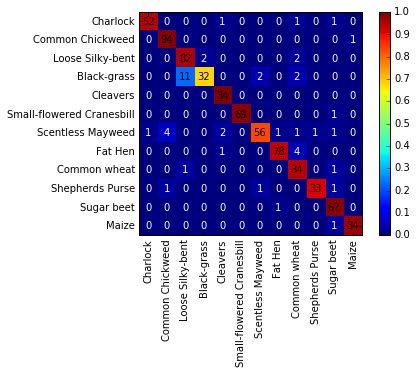

In [18]:
# convert the one-hot encodings back to the "dense" representation
train_labels_dense = np.argmax(train_labels, axis=1)
dev_labels_dense = np.argmax(dev_labels, axis=1)

conf_arr = confusion_matrix(dev_labels_dense, dev_predictions)

norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center',
                    color="white" if norm_conf[x][y] < 0.2 else "black")

cb = fig.colorbar(res)
plt.xticks(range(width), class_names, rotation="vertical")
plt.yticks(range(height), class_names)
None

There is one cell here that clearly stands out. Black-grass gets mistaken for Loose Silky-bent a lot. Let's plot some examples of each class to see why they might get commonly confused.

### Plot the Commonly Confused Classes

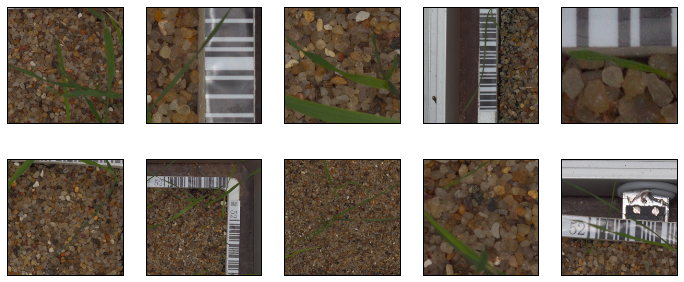

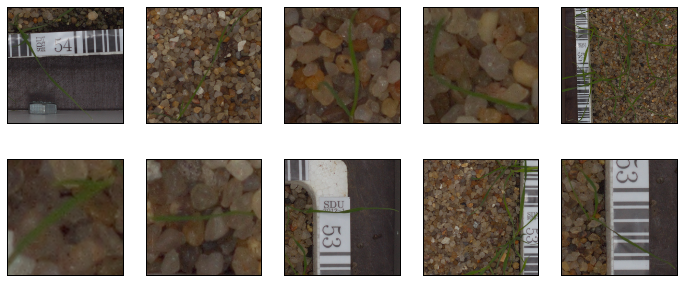

In [7]:
black_grass_imgs = train_data[np.where(train_labels_dense == 3)][:10]
loose_silkybent_imgs = train_data[np.where(train_labels_dense == 2)][:10]

fig1 = plt.figure(figsize=(12, 5))
for i, img in enumerate(black_grass_imgs):
    sub = fig1.add_subplot(2, 5, i + 1)
    sub.imshow(img)
    remove_ticks(sub)
    
fig2 = plt.figure(figsize=(12, 5))
for i, img in enumerate(loose_silkybent_imgs):
    sub = fig2.add_subplot(2, 5, i + 1)
    sub.imshow(img)
    remove_ticks(sub)

The two classes look very similar. This will make them difficult to differentiate. I can't even do it by eye. To make things worse, we saw in part 1 that there are relatively few examples for Black-grass, and more than double the number of Loose Silky-bent. This explains why Black-grass gets commonly mistaken for Loose Silky-Bent, but not the other way around. To address this issue, we could do the data augmentation differently. Before, the same number of transformations were applied on all exampled in the training set. Instead, we could try "evening things out" by applying more transformations to the classes with fewer examples.

## Plotting Greatest Sources of Loss

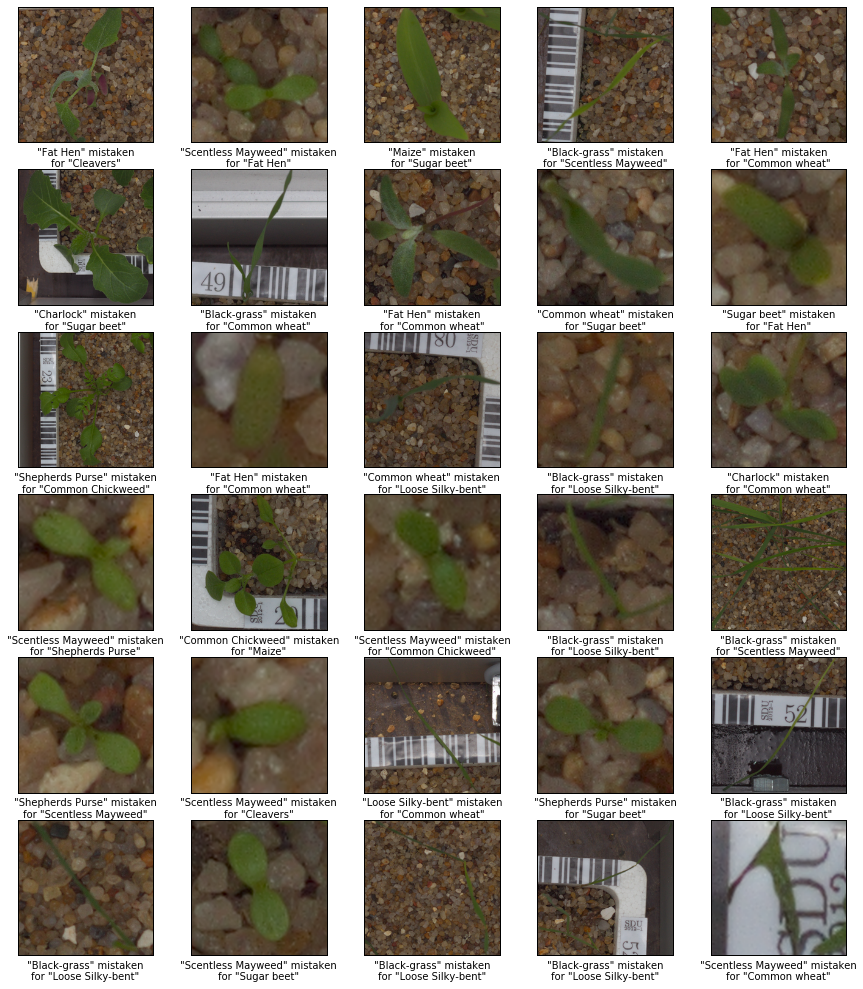

In [8]:
# find the 30 "biggest mistakes" by seeing which of the dev examples produced the highest cost value
n_mistakes = 30
ind_biggest_mistakes = arg_top_n(dev_losses, n_mistakes)[0]

fig = plt.figure(figsize=(15, math.ceil(n_mistakes / 1.8)))
for i, mistake_ind in enumerate(ind_biggest_mistakes):
    sub = fig.add_subplot(math.ceil(n_mistakes / 5), 5, i + 1)
    example = dev_data[mistake_ind]
    sub.imshow(example)
    predicted_class = class_names[dev_predictions[mistake_ind]]
    actual_class = class_names[dev_labels_dense[mistake_ind]]
    sub.set_xlabel('"%s" mistaken\nfor "%s"' % (actual_class, predicted_class))
    remove_ticks(sub)

In these examples, there are a lot of examples of Black-grass confused as Loose Silky-bent. This was expected from the confusion matrix. There are a few examples of grainy, poorly lit photos. However, the biggest issue here seems to be that the small photos are contributing disproportionately more to the loss. Remember that the photos smaller than 224x224 were scaled up. There is relatively less information in the smaller photos, and scaling up doesn't fix that issue. Perhaps there is a better way to preprocess the smaller photos. Zero-padding was attempted but gave worse accuracy. This effectively fills the extra space with black surrouding the image to make it the desired size. Perhaps the giant sections of black were causing issues. We could pad with other things, like synthesizing background, to make the photos look the same as the original distribution. For this, I could train a [GAN](https://en.wikipedia.org/wiki/Generative_adversarial_network) to generate some background. Another alternative is to try to remove the background. Maybe using only the green channel is adequate since most of the green is in the leaves.

## Ideas to Improve Accuracy

- Use more augmentation on classes with fewer examples (especially Black-grass), to balance the classes.
- Instead of scaling the small images, pad with synthesized background.
- Don't keep all the images in memory at once. Load the images in batches to avoid hitting memory limits. This would slow down training, but allow us to synthesize even more data.
- Use only the green channels from the images for training and prediction.